In [1]:
import pandas as pd
import numpy as np
import random
import scipy.optimize as scopt

import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

In [2]:
from game.gradient import GradientComputation
from game.player import Player

In [3]:
community_size = 3

In [4]:
if community_size == 3:
    D_min = [0.0,0.0,0.0]
    D_max = [10.0,10.0,10.0]

    G_min = [0.0,0.0,0.0]
    G_max = [10.0,0.0,0.0]
    
    Kappa = [[0.0, 10.0, 10.0],
             [10.0, 0.0, 5.0],
             [10.0, 5.0, 0.0]]
    
    Cost = [[0.0, 1.0, 1.0],
            [3.0, 0.0, 1.0],
            [2.0, 1.0, 0.0]]
    
    #probabilities = [0.333, 0.333, 0.333]

    probabilities = [0.5, 0.5]
    connection_matrix = [[0,1,1],[1,0,1],[1,1,0]]

In [5]:
A_tilde = [random.uniform(0,1) for i in range(community_size)]
B_tilde = [random.uniform(0,1) for i in range(community_size)]

A = [random.uniform(0,1) for i in range(community_size)]
B = [random.uniform(0,1) for i in range(community_size)]
D = [random.uniform(0,1) for i in range(community_size)]

d_target = [[random.uniform(0,8) for j in range(len(probabilities))] for i in range(community_size)]
g_res = [[random.uniform(0,3) for j in range(len(probabilities))] for i in range(community_size)]

g_res = np.array(g_res)
d_target = np.array(d_target)

risk_aversion = [random.uniform(0,1) for i in range(community_size)]

In [6]:
g_res

array([[2.51780801, 1.27232054],
       [1.47275251, 1.45702091],
       [2.10540607, 0.95236555]])

In [7]:
agents = []
Player.community_size = community_size
Player.probabilities = probabilities

for i in range(community_size):
    agent = Player(i, d_target[i], g_res[i], A[i], B[i], D[i], 
                A_tilde[i], B_tilde[i], D_min[i], D_max[i], 
                G_min[i], G_max[i], risk_aversion[i], Kappa[i], Cost[i], connection_matrix[i])
    
    agents.append(agent)

# AMPL

In [8]:
from amplpy import AMPL, Environment, DataFrame

ampl = AMPL(Environment('/Users/ishilov/Documents/ampl.macos64'))

ampl.read('/Users/ishilov/Documents/risk_paper/risk_paper/ampl/3_nodes_centr.mod')
ampl.readData('/Users/ishilov/Documents/risk_paper/risk_paper/ampl/3_nodes_centr.dat')


In [9]:
nodes = ['n_0', 'n_1', 'n_2']

In [10]:
Cost_dict = {}
for i in range(community_size):
    for j in range(community_size):
        Cost_dict.update({(nodes[i],nodes[j]):Cost[i][j]})

Kappa_dict = {}
for i in range(community_size):
    for j in range(community_size):
        Kappa_dict.update({(nodes[i],nodes[j]):Kappa[i][j]})

In [11]:
d_target_dict = {}
g_res_dict = {}
for i in range(community_size):
    for j in range(len(probabilities)):
        d_target_dict.update({('n_{}'.format(i), 'p_{}'.format(j)): d_target[i][j]})
        g_res_dict.update({('n_{}'.format(i), 'p_{}'.format(j)): g_res[i][j]})

In [12]:
p_dict = {}
for j in range(len(probabilities)):
    p_dict.update({'p_{}'.format(j) : probabilities[j]})

In [13]:
if community_size == 3:

    ampl.getParameter('a').setValues(A)
    ampl.getParameter('b').setValues(B)
    ampl.getParameter('d').setValues(D)
    ampl.getParameter('a_t').setValues(A_tilde)
    ampl.getParameter('b_t').setValues(B_tilde)

    ampl.getParameter('D_max').setValues(D_max)
    ampl.getParameter('G_max').setValues(G_max)
    ampl.getParameter('D_min').setValues(D_min)
    ampl.getParameter('G_min').setValues(G_min)

    ampl.getParameter('chi').setValues(risk_aversion)
    
    ampl.getParameter('cost').setValues(Cost_dict)

    ampl.getParameter('kappa').setValues(Kappa_dict)
    
    ampl.getParameter('p').setValues(p_dict)
                
    ampl.getParameter('D_t').setValues(d_target_dict)
    ampl.getParameter('G_d').setValues(g_res_dict)
    
    # Solve
    ampl.setOption('solver', 'MINOS')
    ampl.solve()

MINOS 5.51: optimal solution found.
82 iterations, objective 13.55353696
Nonlin evals: constrs = 181, Jac = 180.


In [14]:
if community_size ==3:
    g = ampl.getVariable('G').getValues().toDict()
    d = ampl.getVariable('D').getValues().toDict()
    u = ampl.getVariable('u').getValues().toDict()
    eta = ampl.getVariable('eta').getValues().toDict()
    q = ampl.getVariable('quant').getValues().toDict()
    Q = ampl.getVariable('Q').getValues().toDict()

In [15]:
ampl.display('G')

G :=
n_0 p_0   0.106151
n_0 p_1   1.40819
;



In [16]:
def assign_ampl(d, g, eta, u, q, agents):
    """Assigns the solution from AMPL to agents"""

    for i in range(community_size):
        id = 'n_{}'.format(i)

        for j in range(len(probabilities)):
            proba = 'p_{}'.format(j)
            agents[i].D[j] = d[(id, proba)]

    for i in range(community_size):
        id = 'n_{}'.format(i)

        for j in range(len(probabilities)):
            proba = 'p_{}'.format(j)
            agents[i].G[j] = g[(id, proba)]

    for i in range(community_size):
        id = 'n_{}'.format(i)

        for j in range(len(probabilities)):
            proba = 'p_{}'.format(j)
            agents[i].u[j] = u[(id, proba)]

    for i in range(community_size):
        id = 'n_{}'.format(i)

        agents[i].eta = eta[id]

    for i in range(community_size):
        id_1 = 'n_{}'.format(i)

        for j in range(community_size):
            id_2 = 'n_{}'.format(j)

            for k in range(len(probabilities)):
                proba = 'p_{}'.format(k)

                agents[i].q[j][k] = q[(id_1, id_2, proba)]

In [17]:
assign_ampl(d,g,eta,u,q,agents)

# Gradient

In [18]:
Player.probabilities

[0.5, 0.5]

In [19]:
agents[0].__dict__

{'id': 0,
 'D_target': array([4.91792319, 6.94652227]),
 'G_res': array([2.51780801, 1.27232054]),
 'a': 0.7965832390054818,
 'b': 0.4921624593627649,
 'd': 0.6036335430450974,
 'a_tilde': 0.20799567845170475,
 'b_tilde': 0.3491501145693269,
 'D_min': 0.0,
 'D_max': 10.0,
 'G_min': 0.0,
 'G_max': 10.0,
 'risk_aversion': 0.7297410981415337,
 'probabilities_ind': [0, 1],
 'trading_cost': [0.0, 1.0, 1.0],
 'connections': [0, 1, 1],
 'kappa': array([ 0., 10., 10.]),
 'G': array([0.10615075, 1.40818552]),
 'D': array([2.1733473 , 3.06687571]),
 'eta': 5.2543957154992675,
 'u': array([0., 0.]),
 'q': array([[ 0.        ,  0.        ],
        [ 3.21916795,  4.50788266],
        [-3.66977942, -4.12151301]]),
 'grad_G': array([0., 0.]),
 'grad_D': array([0., 0.]),
 'grad_eta': 0,
 'grad_u': array([0., 0.]),
 'grad_q': array([[0., 0.],
        [0., 0.],
        [0., 0.]]),
 'plot_d': [[], []],
 'plot_g': [[], []],
 'plot_u': [[], []],
 'plot_eta': [],
 'plot_q': [[[], []], [[], []], [[], []]]}

In [20]:
for i in range(community_size):
    print('Utility update:')
    print(GradientComputation.utility_grad(agents[i]))
    print('-------')
    print('D_min bound')
    print(GradientComputation.penalty_dmin(agents[i]))
    print('-------')
    print('D_max bound')
    print(GradientComputation.penalty_dmax(agents[i]))
    print('-------')
    print('G_min bound')
    print(GradientComputation.penalty_gmin(agents[i]))
    print('-------')
    print('G_max bound')
    print(GradientComputation.penalty_gmax(agents[i]))
    print('-------')
    print('Penalty supply-demand balance bound')
    print(GradientComputation.penalty_balance(agents[i]))
    print('-------')
    print('U bound')
    print(GradientComputation.penalty_u(agents[i]))
    print('-------')
    print('Penalty trading bound')
    print(GradientComputation.penalty_trading_bound(agents[i]))
    print('-------')
    print('Bilateral trading bound')
    print(GradientComputation.penalty_bilateral_trading(agents[i], agents))
    print('-------')
    print('Penalty residual bound')
    print(GradientComputation.penalty_residual(agents[i]))
    print('----------------------------------------------')

Utility update:
{'update_eta': 1, 'update_u': array([1.85007782, 1.85007782])}
-------
D_min bound
[0 0]
-------
D_max bound
[0 0]
-------
G_min bound
[0 0]
-------
G_max bound
[0 0]
-------
Penalty supply-demand balance bound
{'update_d': array([-1.60982339e-15, -2.22044605e-16]), 'update_g': array([1.60982339e-15, 2.22044605e-16]), 'update_q': array([[0.00000000e+00, 0.00000000e+00],
       [1.60982339e-15, 2.22044605e-16],
       [1.60982339e-15, 2.22044605e-16]])}
-------
U bound
[0. 0.]
-------
Penalty trading bound
[[0. 0.]
 [0. 0.]
 [0. 0.]]
-------
Bilateral trading bound
[[0.00000000e+00 0.00000000e+00]
 [1.33226763e-15 2.66453526e-15]
 [0.00000000e+00 0.00000000e+00]]
-------
Penalty residual bound
{'update_d': array([-0.0000000e+00, -2.8668613e-15]), 'update_g': array([0.00000000e+00, 4.85946647e-15]), 'update_eta': -1.7763568394002505e-15, 'update_u': array([-0.00000000e+00, -1.77635684e-15]), 'update_q': array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.77

In [21]:
mu = 0.03
rho = 500
k = 0
while k <= 6000:
    #print(k)
    #print('--------------------------')
    for agent in agents:
        #Update of grad_d of the agent

        agent.grad_D = rho*(GradientComputation.penalty_dmin(agent) 
                            + GradientComputation.penalty_dmax(agent)
                            + GradientComputation.penalty_balance(agent)['update_d']
                            + GradientComputation.penalty_residual(agent)['update_d'])

        agent.grad_G = rho*(GradientComputation.penalty_gmin(agent) 
                            + GradientComputation.penalty_gmax(agent)
                            + GradientComputation.penalty_balance(agent)['update_g']
                            + GradientComputation.penalty_residual(agent)['update_g'])

        agent.grad_eta = (GradientComputation.utility_grad(agent)['update_eta']
                        + rho*GradientComputation.penalty_residual(agent)['update_eta'])

        agent.grad_u = (GradientComputation.utility_grad(agent)['update_u']
                        + rho*GradientComputation.penalty_residual(agent)['update_u']
                        + rho*GradientComputation.penalty_u(agent))



        agent.grad_q = rho*(GradientComputation.penalty_trading_bound(agent)
                            + GradientComputation.penalty_residual(agent)['update_q']
                            + GradientComputation.penalty_balance(agent)['update_q']
                            + GradientComputation.penalty_bilateral_trading(agent, agents))


        

        #print('Agent {} variables'.format(agent.id))
        #print(agent.variables_to_vector())
        #print('--------------------------------')

    #Agent's variables update
    for agent in agents:

        N = k + 500

        agent.D = agent.D - mu/(N)*agent.grad_D
        agent.G = agent.G - mu/(N)*agent.grad_G
        agent.eta = agent.eta - mu/(N)*agent.grad_eta
        agent.u = agent.u - mu/(N)*agent.grad_u
        agent.q = agent.q - mu/(N)*agent.grad_q

        agent.plot_eta.append(agent.eta)

        for i in range(len(probabilities)):
            agent.plot_d[i].append(agent.D[i])
            agent.plot_g[i].append(agent.G[i])
            agent.plot_u[i].append(agent.u[i])

            for agent_2 in agents:
                agent.plot_q[agent_2.id][i].append(agent.q[agent_2.id][i])
    
    

    k +=1

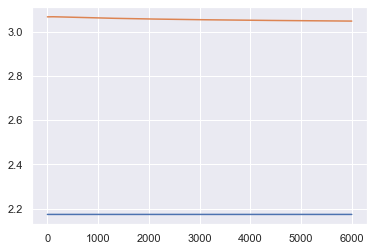

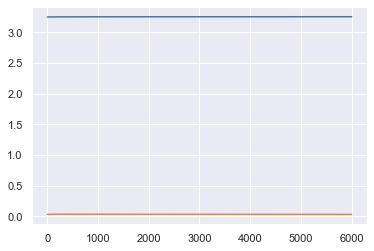

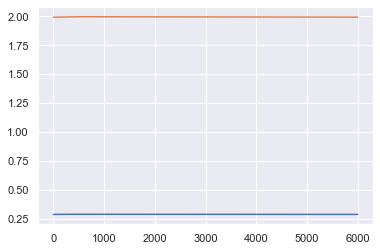

In [22]:
for agent in agents:
    for i in range(len(probabilities)):
        plt.plot(agent.plot_d[i])
    
    plt.show()

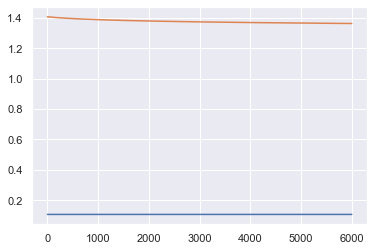

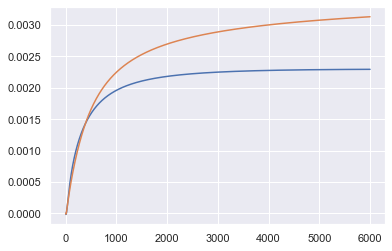

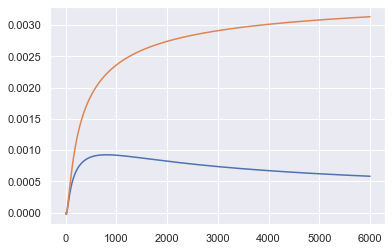

In [23]:
for agent in agents:
    for i in range(len(probabilities)):
        plt.plot(agent.plot_g[i])
    
    plt.show()

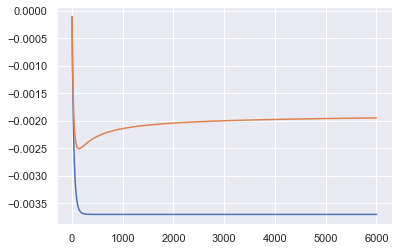

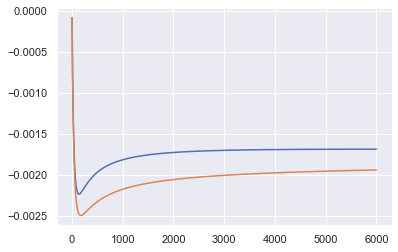

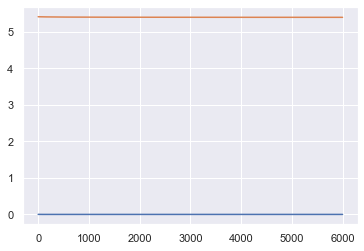

In [24]:
for agent in agents:
    for i in range(len(probabilities)):
        plt.plot(agent.plot_u[i])
    
    plt.show()

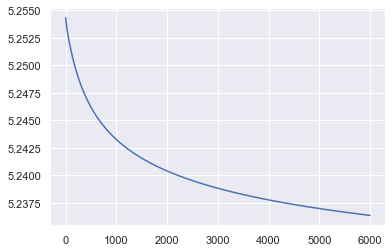

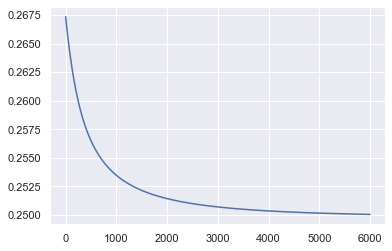

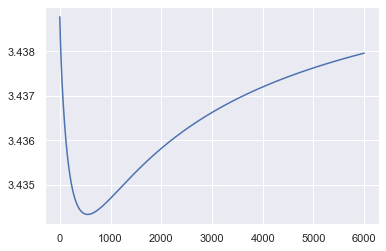

In [25]:
for agent in agents:
    plt.plot(agent.plot_eta)
    
    plt.show()

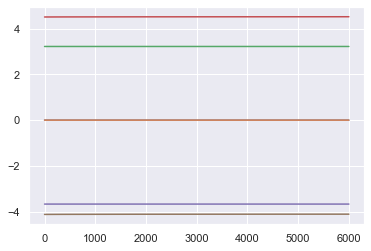

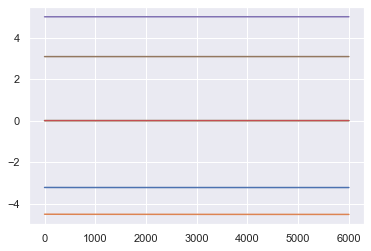

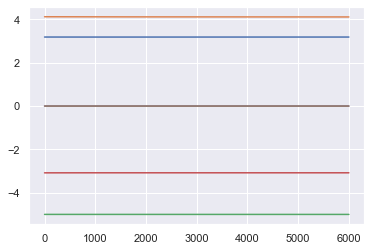

In [26]:
for agent in agents:
    for agent_2 in agents:
        for i in range(len(probabilities)):
            plt.plot(agent.plot_q[agent_2.id][i])

    plt.show()

In [27]:
for agent in agents:
    print('Demand of agent {}'.format(agent.id))
    print(agent.D)
    print('-----')
    print('Generation of agent {}'.format(agent.id))
    print(agent.G)
    print('-----')
    print('Trades of agent {}'.format(agent.id))
    print(agent.q)
    print('-----')
    print('U of agent {}'.format(agent.id))
    print(agent.u)
    print('-----')
    print('Eta of agent {}'.format(agent.id))
    print(agent.eta)
    print('-----')
    print('-----------------------------')

Demand of agent 0
[2.1733473  3.04769078]
-----
Generation of agent 0
[0.10615075 1.36369809]
-----
Trades of agent 0
[[ 0.          0.        ]
 [ 3.21916795  4.51862778]
 [-3.66977942 -4.11050194]]
-----
U of agent 0
[-0.00370016 -0.00194746]
-----
Eta of agent 0
5.236371322687014
-----
-----------------------------
Demand of agent 1
[3.25714669 0.03032525]
-----
Generation of agent 1
[0.00229317 0.00312981]
-----
Trades of agent 1
[[-3.22282777 -4.51705541]
 [ 0.          0.        ]
 [ 5.00162582  3.08329572]]
-----
U of agent 1
[-0.00168761 -0.00194078]
-----
Eta of agent 1
0.2500404450973087
-----
-----------------------------
Demand of agent 2
[0.29067214 1.99196712]
-----
Generation of agent 2
[0.00058231 0.00313361]
-----
Trades of agent 2
[[ 3.18474323  4.11207774]
 [-5.00107016 -3.08026135]
 [ 0.          0.        ]]
-----
U of agent 2
[-1.19702685e-03  5.39691006e+00]
-----
Eta of agent 2
3.437957517052769
-----
-----------------------------


In [28]:
for i,j in enumerate(reversed([1,2,3,5])):
    print(i,j)

0 5
1 3
2 2
3 1


In [29]:
c = [1,2,3]

In [30]:
a = b = c

In [31]:
a

[1, 2, 3]

In [32]:
c[0] = 5

In [33]:
from game.stackelberg import StackelbergPlayer
from game.stackelberg import StackelbergGradientComputation

In [34]:
import numpy as np

a = np.array([[1,2,3],[4,5,6]])
a.sum()

21

In [35]:
class myclass:
    def foo(self, lst):
        self.c = lst

    def func(self):
        self.a = self.b = self.c

    def mod_c(self):
        self.c[0] = 5

    def fooo(self):
        self.a = 10
        self.b = 7

In [1]:
import gurobipy